# Adding copy number covariate to the hierarchical negative binomial model

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
from pathlib import Path
from time import time

import arviz as az
import janitor  # noqa: F401
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc as pm
import seaborn as sns

In [3]:
from speclet.analysis.arviz_analysis import extract_matrix_variable_coords
from speclet.bayesian_models.hierarchical_nb import HierarchcalNegativeBinomialModel
from speclet.data_processing.common import make_cat
from speclet.io import DataFile
from speclet.managers.data_managers import CrisprScreenDataManager
from speclet.plot.plotnine_helpers import set_gg_theme
from speclet.project_configuration import read_project_configuration
from speclet.project_enums import ModelFitMethod

In [4]:
# Notebook execution timer.
notebook_tic = time()

# Plotting setup.
set_gg_theme()
%config InlineBackend.figure_format = "retina"

# Constants
RANDOM_SEED = 847
np.random.seed(RANDOM_SEED)
HDI_PROB = read_project_configuration().modeling.highest_density_interval

## Prepare model object and data

In [5]:
hnb = HierarchcalNegativeBinomialModel()

In [6]:
dm = CrisprScreenDataManager(DataFile.DEPMAP_CRC_BONE_SUBSAMPLE)
counts_data = dm.get_data()

In [7]:
for col in ["hugo_symbol", "sgrna", "depmap_id", "lineage"]:
    print(f"{col}: {counts_data[col].nunique()}")

hugo_symbol: 113
sgrna: 338
depmap_id: 10
lineage: 2


In [8]:
valid_ct_data = hnb.data_processing_pipeline(counts_data.copy())
model_data = hnb._make_data_structure(valid_ct_data)

/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


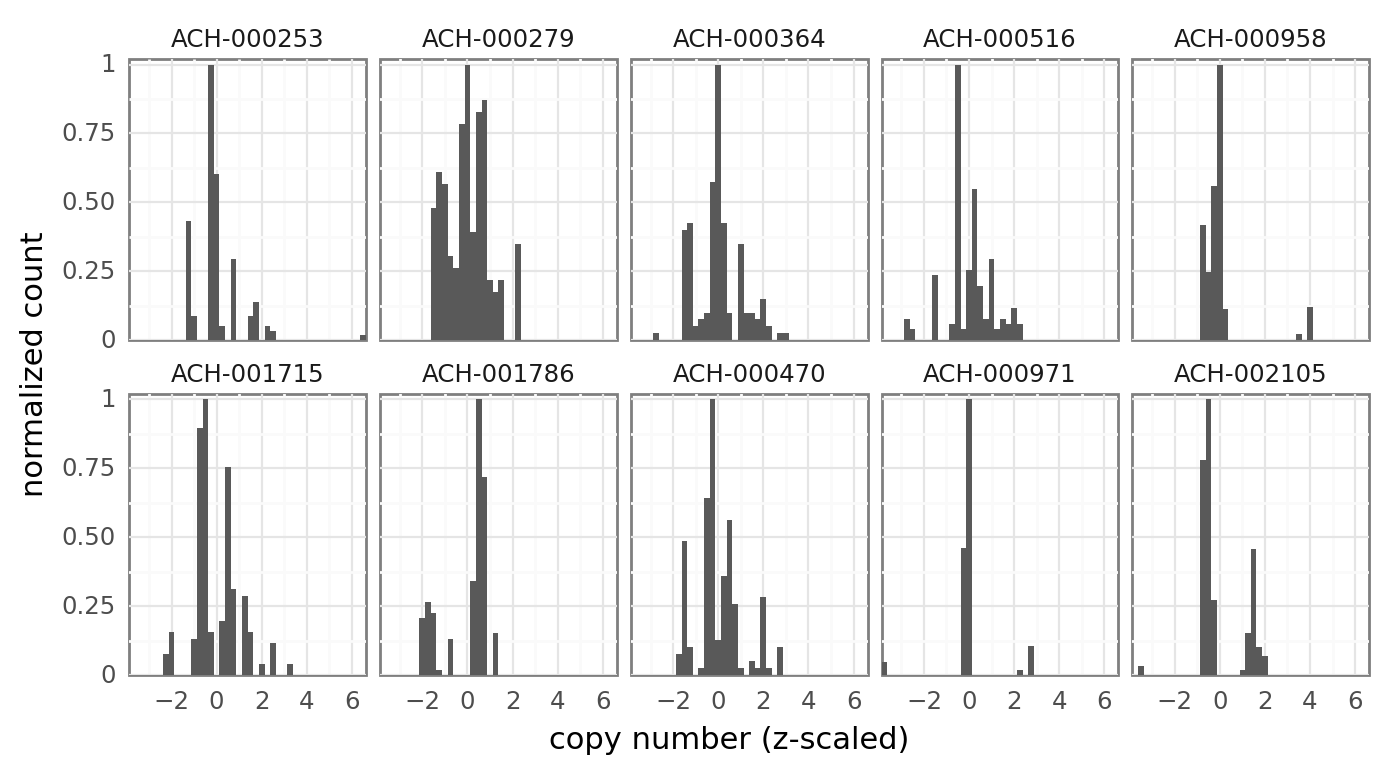

<ggplot: (351200726)>

In [9]:
(
    gg.ggplot(valid_ct_data, gg.aes(x="z_cn_cell_line"))
    + gg.facet_wrap("~ depmap_id", nrow=2)
    + gg.geom_histogram(gg.aes(y=gg.after_stat("ncount")), binwidth=0.25)
    + gg.scale_y_continuous(expand=(0, 0, 0.02, 0))
    + gg.scale_x_continuous(expand=(0, 0))
    + gg.theme(figure_size=(8, 4))
    + gg.labs(x="copy number (z-scaled)", y="normalized count")
)

/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


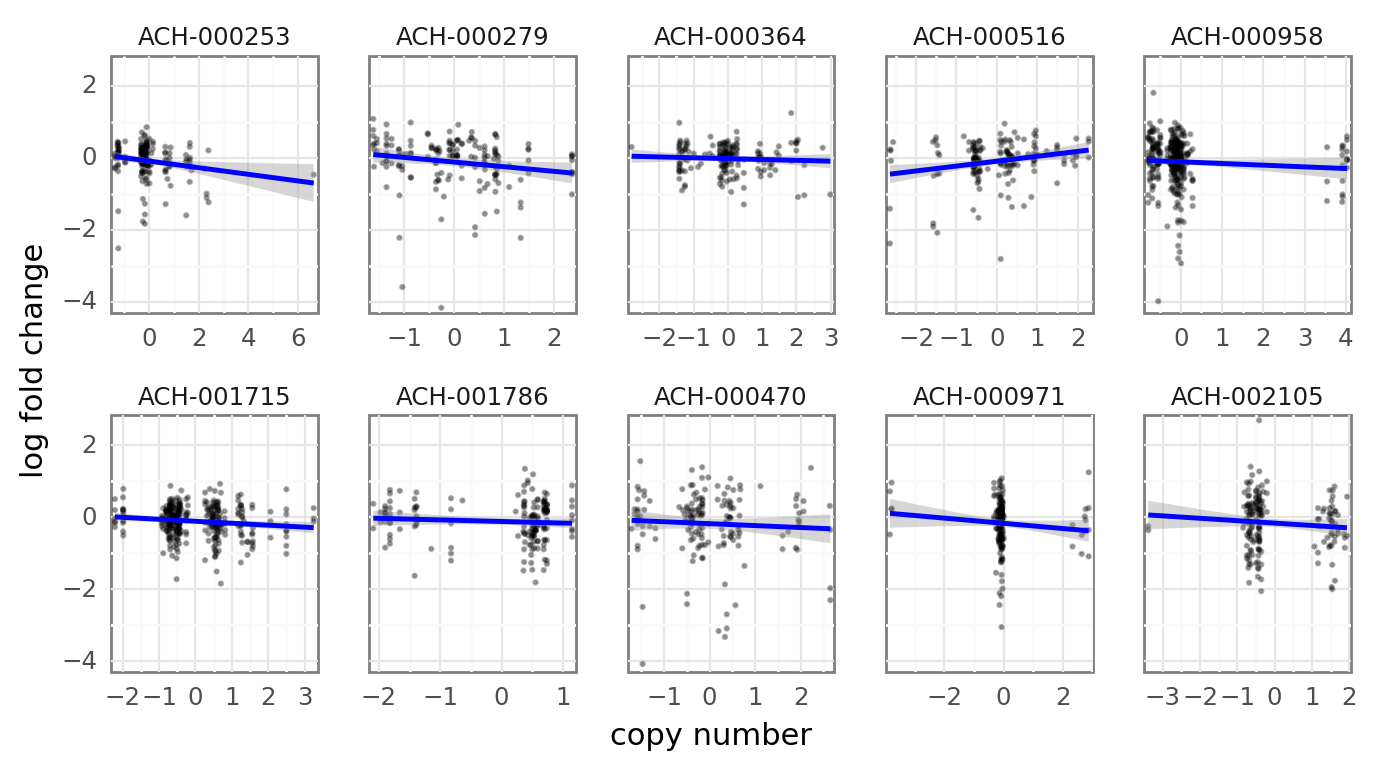

<ggplot: (351704471)>

In [10]:
(
    gg.ggplot(valid_ct_data, gg.aes(x="z_cn_cell_line", y="lfc"))
    + gg.facet_wrap("~ depmap_id", nrow=2, scales="free_x")
    + gg.geom_point(size=0.3, alpha=0.3)
    + gg.geom_smooth(formula="y ~ x", method="lm", color="blue")
    + gg.scale_y_continuous(expand=(0.02, 0))
    + gg.scale_x_continuous(expand=(0.02, 0))
    + gg.theme(figure_size=(8, 4), subplots_adjust={"wspace": 0.25, "hspace": 0.4})
    + gg.labs(x="copy number", y="log fold change")
)

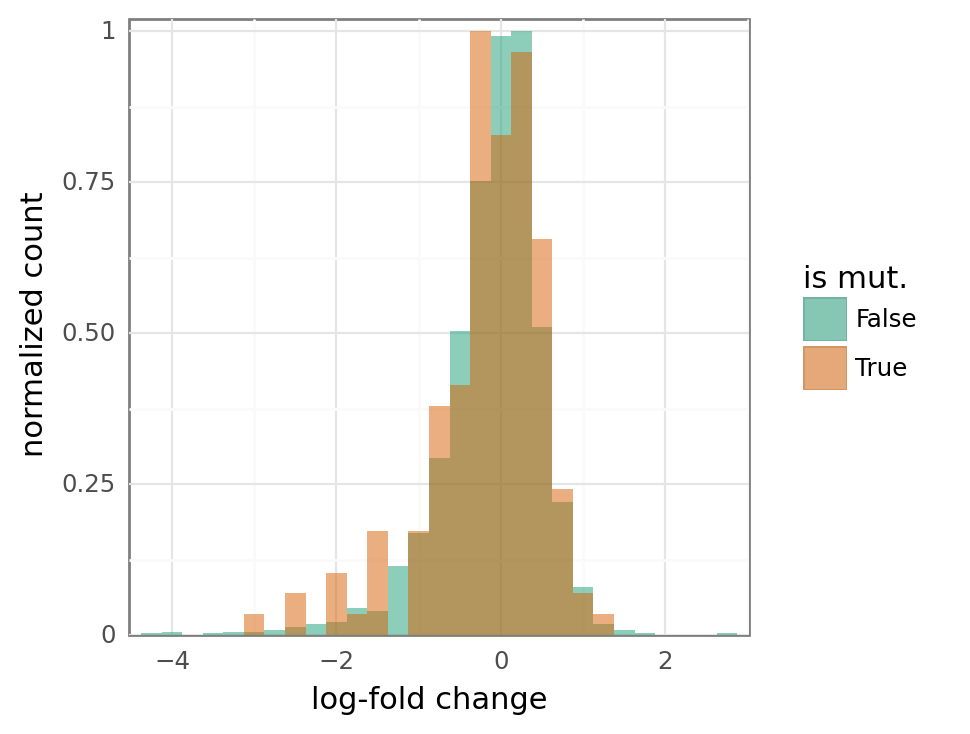

<ggplot: (352047869)>

In [11]:
(
    gg.ggplot(valid_ct_data, gg.aes(x="lfc"))
    + gg.geom_histogram(
        gg.aes(fill="is_mutated", y=gg.after_stat("ncount")),
        binwidth=0.25,
        position="identity",
        alpha=0.5,
    )
    + gg.scale_x_continuous(expand=(0.02, 0))
    + gg.scale_y_continuous(expand=(0, 0, 0.02, 0))
    + gg.scale_fill_brewer(type="qual", palette="Dark2")
    + gg.labs(x="log-fold change", y="normalized count", fill="is mut.")
)

/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.9/site-packages/mizani/palettes.py:397: UserWarning: Warning message:Brewer palette Dark2 has a maximum of 8 colors Returning the palette you asked for with that many colors
/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.9/site-packages/mizani/palettes.py:397: UserWarning: Warning message:Brewer palette Dark2 has a maximum of 8 colors Returning the palette you asked for with that many colors


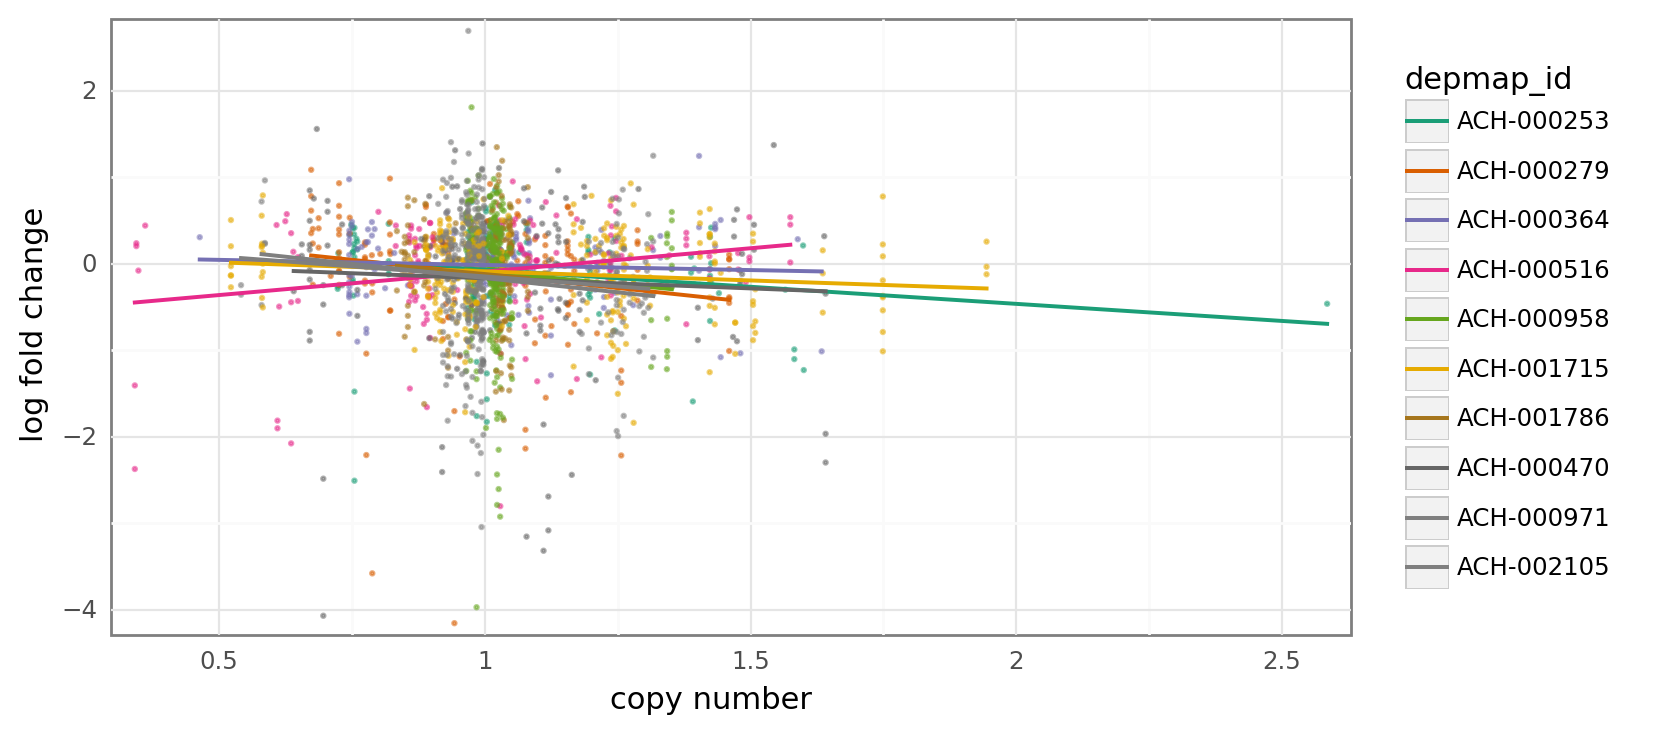

<ggplot: (352098557)>

In [12]:
(
    gg.ggplot(valid_ct_data, gg.aes(x="copy_number", y="lfc", color="depmap_id"))
    + gg.geom_point(size=0.3, alpha=0.5, show_legend=False)
    + gg.geom_smooth(formula="y ~ x", method="lm", se=False, linetype="-", size=0.8)
    + gg.scale_y_continuous(expand=(0.02, 0))
    + gg.scale_x_continuous(expand=(0.02, 0))
    + gg.scale_color_brewer(type="qual", palette="Dark2")
    + gg.theme(figure_size=(8, 4), subplots_adjust={"wspace": 0.25, "hspace": 0.25})
    + gg.labs(x="copy number", y="log fold change")
)

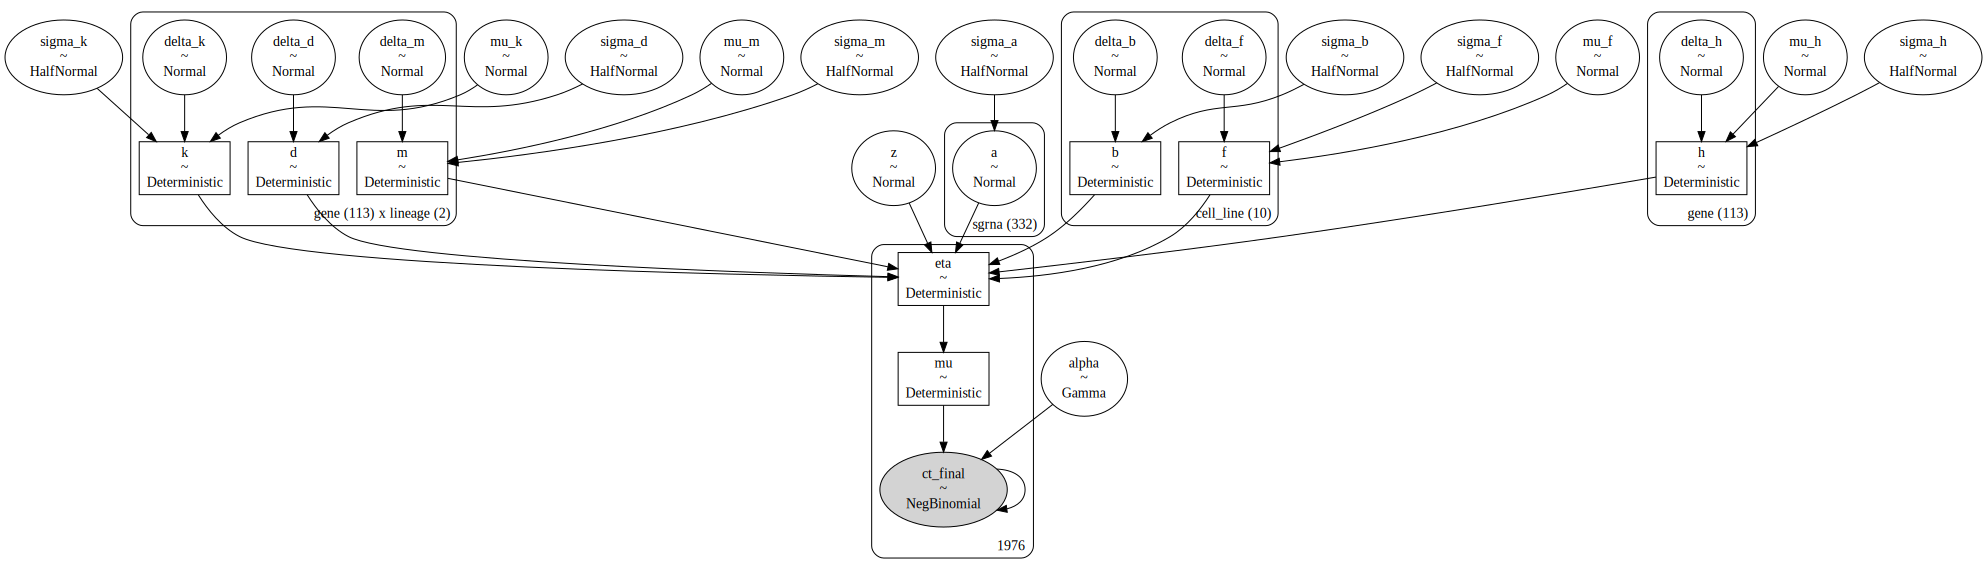

In [13]:
hnb_model = hnb.pymc_model(data=counts_data)
pm.model_to_graphviz(hnb_model)

## Sample posterior

In [14]:
with hnb_model:
    hnb_trace = pm.sample(
        draws=500,
        tune=1000,
        chains=2,
        random_seed=RANDOM_SEED + 1,
        target_accept=0.95,
        return_inferencedata=True,
    )
    pm.sample_posterior_predictive(
        hnb_trace, random_seed=RANDOM_SEED, extend_inferencedata=True, progressbar=False
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [z, sigma_a, a, sigma_b, delta_b, sigma_d, delta_d, mu_f, sigma_f, delta_f, mu_h, sigma_h, delta_h, mu_k, sigma_k, delta_k, mu_m, sigma_m, delta_m, alpha]


Sampling 2 chains for 1_000 tune and 500 draw iterations (2_000 + 1_000 draws total) took 203 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.
/var/folders/r4/qpcdgl_14hbd412snp1jnv300000gn/T/ipykernel_90578/3676164313.py:10: FutureWarning: In this version, RNG seeding is managed by the Model objects. See the `rng_seeder` argument in Model's constructor.


## Posterior analysis

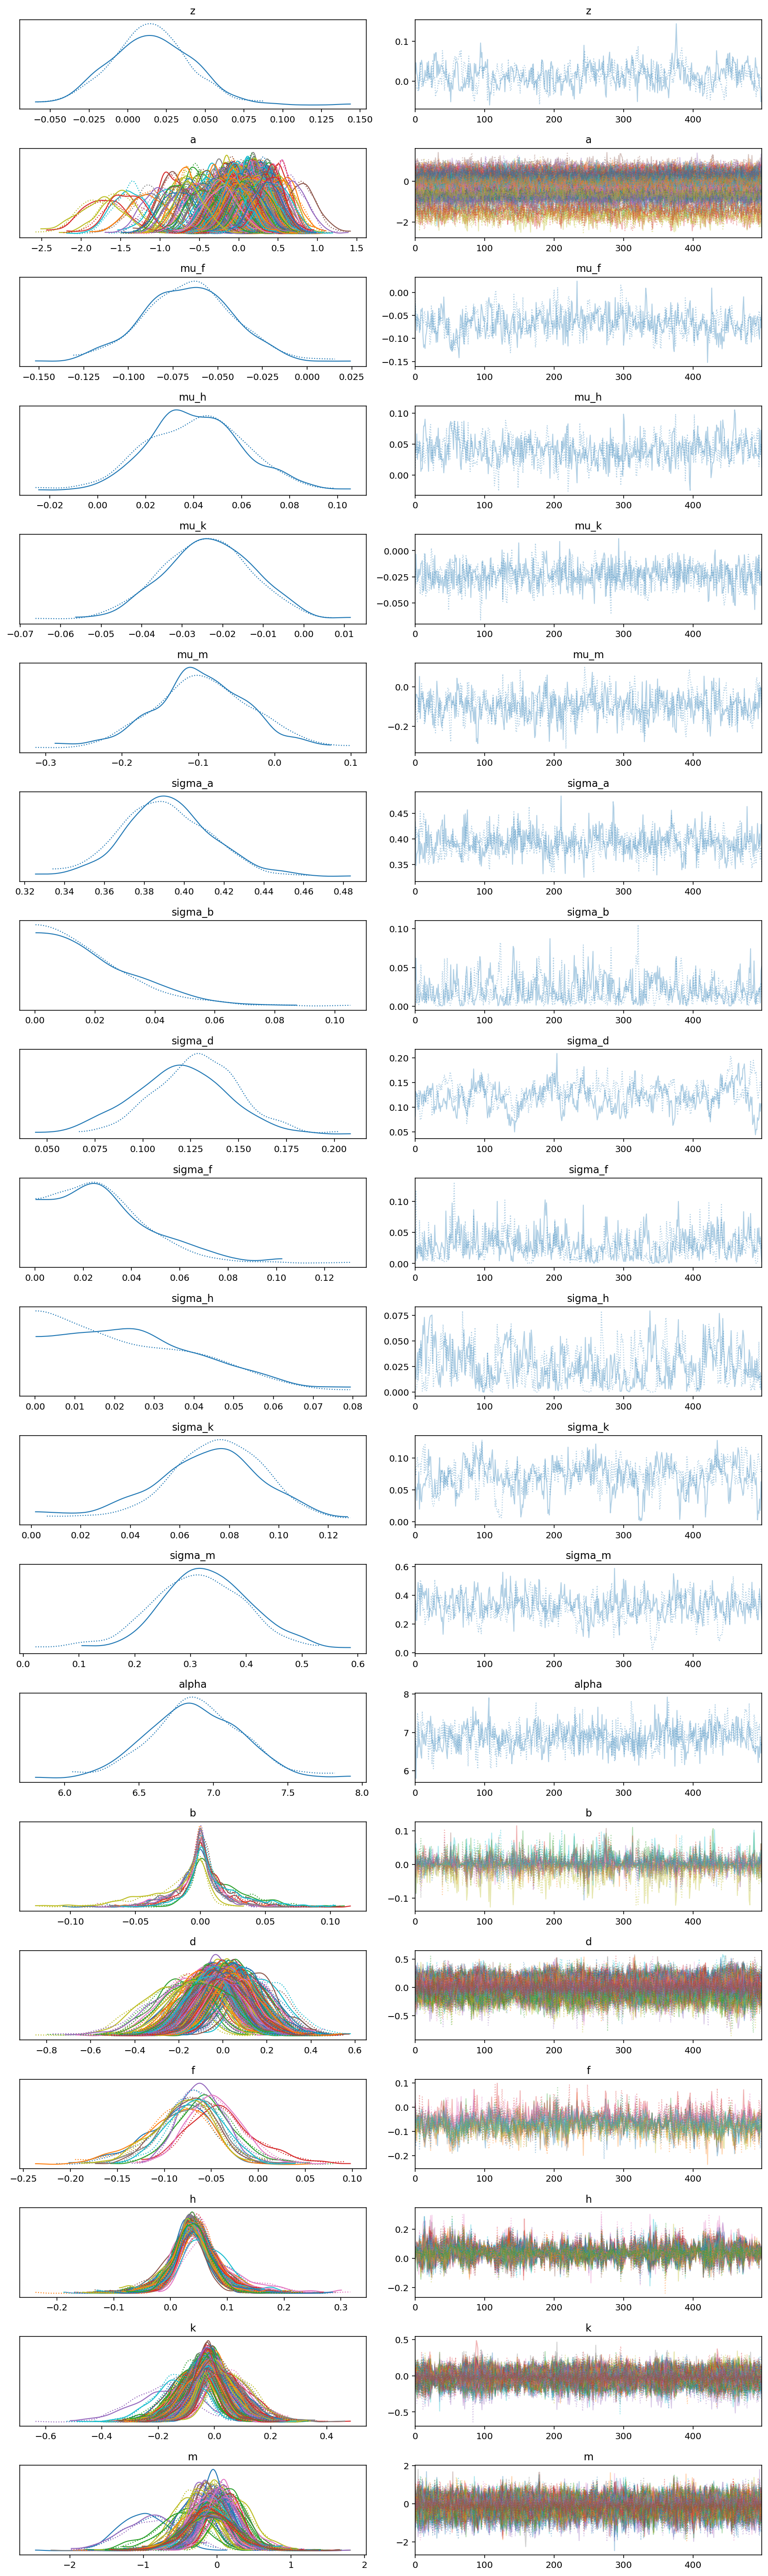

In [15]:
az.plot_trace(
    hnb_trace,
    var_names=hnb.vars_regex(fit_method=ModelFitMethod.PYMC_MCMC),
    filter_vars="regex",
)
plt.tight_layout();

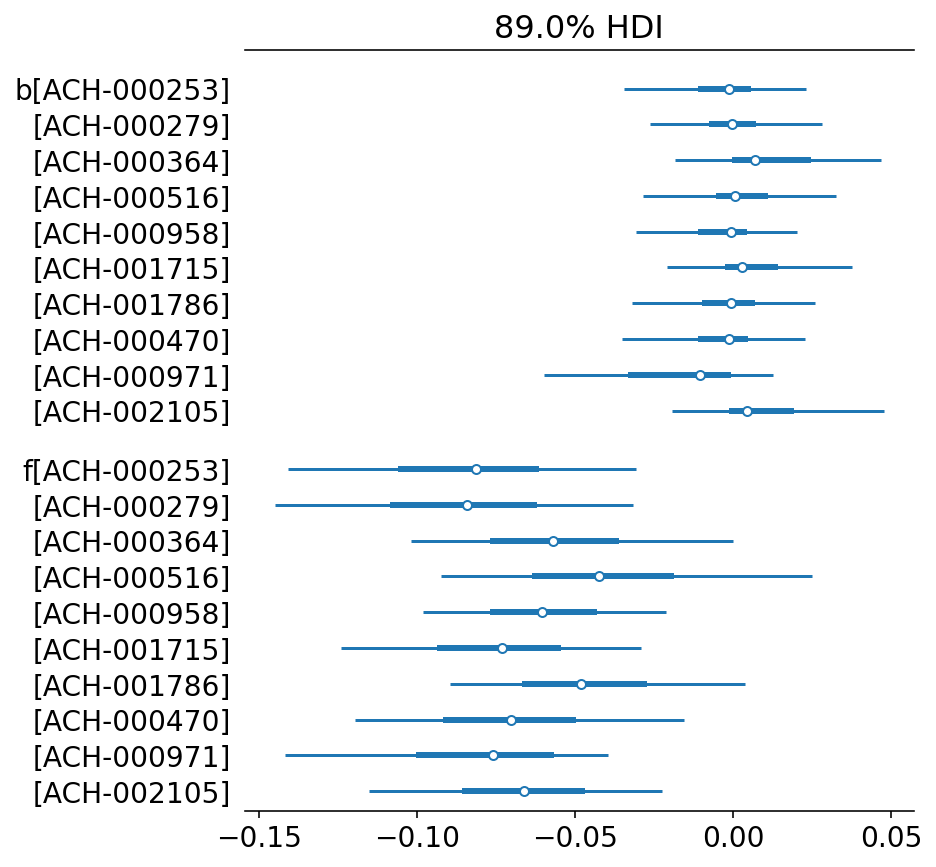

In [16]:
az.plot_forest(hnb_trace, var_names=["b", "f"], hdi_prob=HDI_PROB, combined=True);

In [17]:
eta_post = (
    az.summary(hnb_trace, var_names=["eta"], hdi_prob=HDI_PROB, kind="stats")
    .reset_index()
    .rename({"index": "eta_param"})
)
eta_post.head()

index   mean     sd  hdi_5.5%  hdi_94.5%
0  eta[0]  0.142  0.169    -0.130      0.407
1  eta[1] -0.507  0.184    -0.808     -0.217
2  eta[2] -0.791  0.180    -1.108     -0.531
3  eta[3]  0.529  0.151     0.302      0.775
4  eta[4] -0.187  0.158    -0.436      0.063

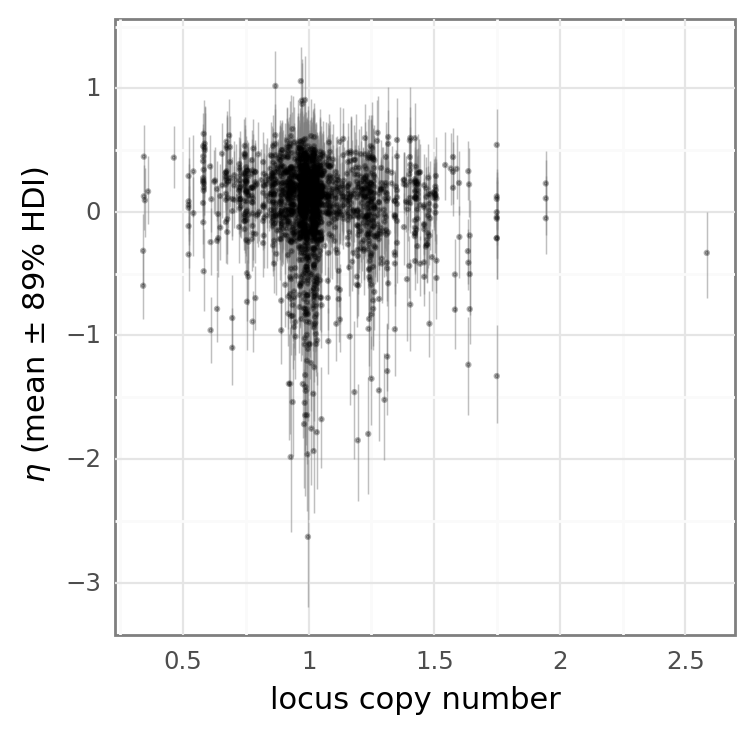

<ggplot: (361536284)>

In [18]:
_plot_df = valid_ct_data.copy().merge(eta_post, left_index=True, right_index=True)
(
    gg.ggplot(_plot_df, gg.aes(x="copy_number", y="mean"))
    + gg.geom_linerange(
        gg.aes(ymin="hdi_5.5%", ymax="hdi_94.5%"), size=0.3, alpha=0.5, color="gray"
    )
    + gg.geom_point(size=0.3, alpha=0.3)
    + gg.labs(x="locus copy number", y="$\eta$ (mean ± 89% HDI)")
)

In [19]:
m_post_summary = (
    az.summary(hnb_trace, var_names=["m"], hdi_prob=HDI_PROB, kind="stats")
    .reset_index(drop=False)
    .pipe(
        extract_matrix_variable_coords,
        col="index",
        idx1name="hugo_symbol",
        idx2name="lineage",
    )
)

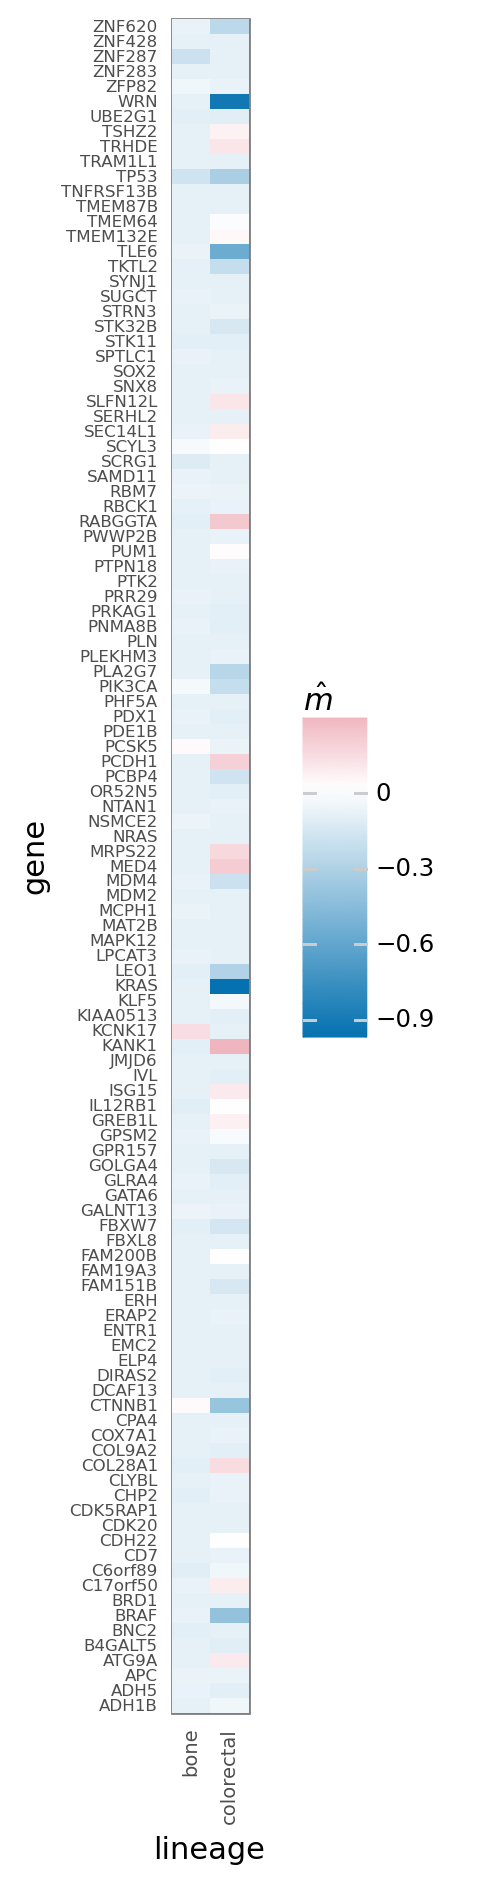

<ggplot: (361535076)>

In [20]:
(
    gg.ggplot(m_post_summary, gg.aes(x="lineage", y="hugo_symbol"))
    + gg.geom_tile(gg.aes(fill="mean"))
    + gg.scale_x_discrete(expand=(0, 0.5))
    + gg.scale_y_discrete(expand=(0, 0.5))
    + gg.scale_fill_gradient2(low="#0571b0", mid="white", high="#ca0020", midpoint=0)
    + gg.theme(
        figure_size=(0.5, 11),
        axis_text_x=gg.element_text(size=7, angle=90),
        axis_text_y=gg.element_text(size=6),
        panel_grid=gg.element_blank(),
    )
    + gg.labs(x="lineage", y="gene", fill="$\\hat{m}$")
)

In [21]:
def filter_hdi_across_zero(
    df: pd.DataFrame, hdi_low: str = "hdi_5.5%", hdi_high: str = "hdi_94.5%"
) -> pd.DataFrame:
    return df.query(
        f"(`{hdi_low}` < 0 and `{hdi_high}` < 0) or (`{hdi_low}` > 0 and `{hdi_high}` > 0)"
    ).reset_index(drop=True)

In [22]:
m_post_summary_sig = filter_hdi_across_zero(m_post_summary)
m_post_summary_sig

index   mean     sd  hdi_5.5%  hdi_94.5% hugo_symbol  \
0    m[KRAS, colorectal] -0.937  0.347    -1.466     -0.364        KRAS   
1  m[CTNNB1, colorectal] -0.386  0.224    -0.705     -0.007      CTNNB1   
2     m[WRN, colorectal] -0.892  0.378    -1.455     -0.209         WRN   
3    m[TLE6, colorectal] -0.544  0.355    -1.145     -0.015        TLE6   

      lineage  
0  colorectal  
1  colorectal  
2  colorectal  
3  colorectal

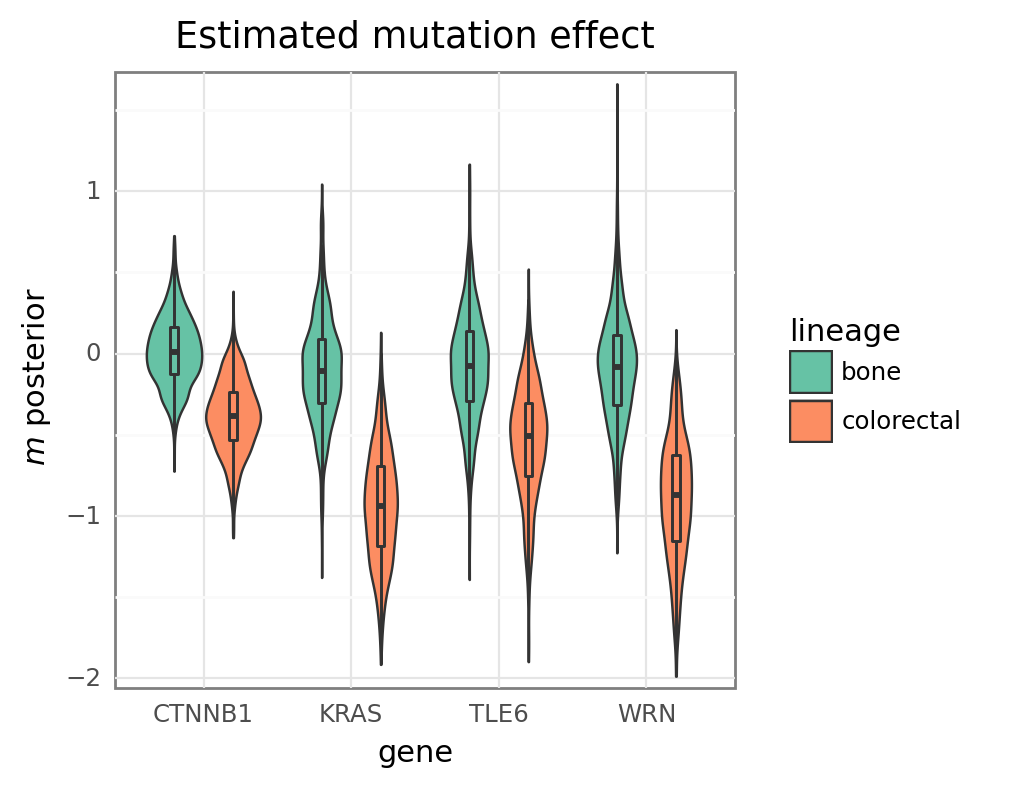

<ggplot: (361775345)>

In [23]:
m_post_sig = (
    hnb_trace.posterior["m"]
    .to_dataframe()
    .reset_index(drop=False)
    .drop(columns=["chain", "draw"])
    .filter_column_isin("gene", m_post_summary_sig.hugo_symbol.unique())
)

pos = gg.position_dodge(width=0.8)

(
    gg.ggplot(m_post_sig, gg.aes(x="gene", y="m"))
    + gg.geom_violin(gg.aes(fill="lineage"), position=pos, width=0.75)
    + gg.geom_boxplot(
        gg.aes(fill="lineage"),
        alpha=0,
        width=0.1,
        size=0.6,
        outlier_alpha=0,
        position=pos,
        show_legend=False,
    )
    + gg.scale_y_continuous(expand=(0.02, 0))
    + gg.scale_fill_brewer(type="qual", palette="Set2")
    + gg.labs(
        x="gene", y="$m$ posterior", fill="lineage", title="Estimated mutation effect"
    )
)

TODO:

1. analyze CN effects
2. analyze RNA effects
3. posterior predictive check

In [24]:
def set_cat_inorder(df: pd.DataFrame, col: str) -> pd.DataFrame:
    df[col] = pd.Categorical(df[col], categories=df[col].unique(), ordered=True)
    return df

In [25]:
gene_cat = valid_ct_data.hugo_symbol.cat.categories
h_post_summary = (
    az.summary(hnb_trace, var_names="h", hdi_prob=HDI_PROB, kind="stats")
    .assign(hugo_symbol=gene_cat)
    .sort_values("mean")
    .pipe(make_cat, "hugo_symbol")
)
h_post_summary.head()

mean     sd  hdi_5.5%  hdi_94.5% hugo_symbol
h[LEO1]     0.021  0.041    -0.042      0.082        LEO1
h[SPTLC1]   0.026  0.039    -0.035      0.081      SPTLC1
h[TMEM87B]  0.028  0.037    -0.035      0.079     TMEM87B
h[NRAS]     0.028  0.039    -0.031      0.090        NRAS
h[APC]      0.029  0.037    -0.034      0.082         APC

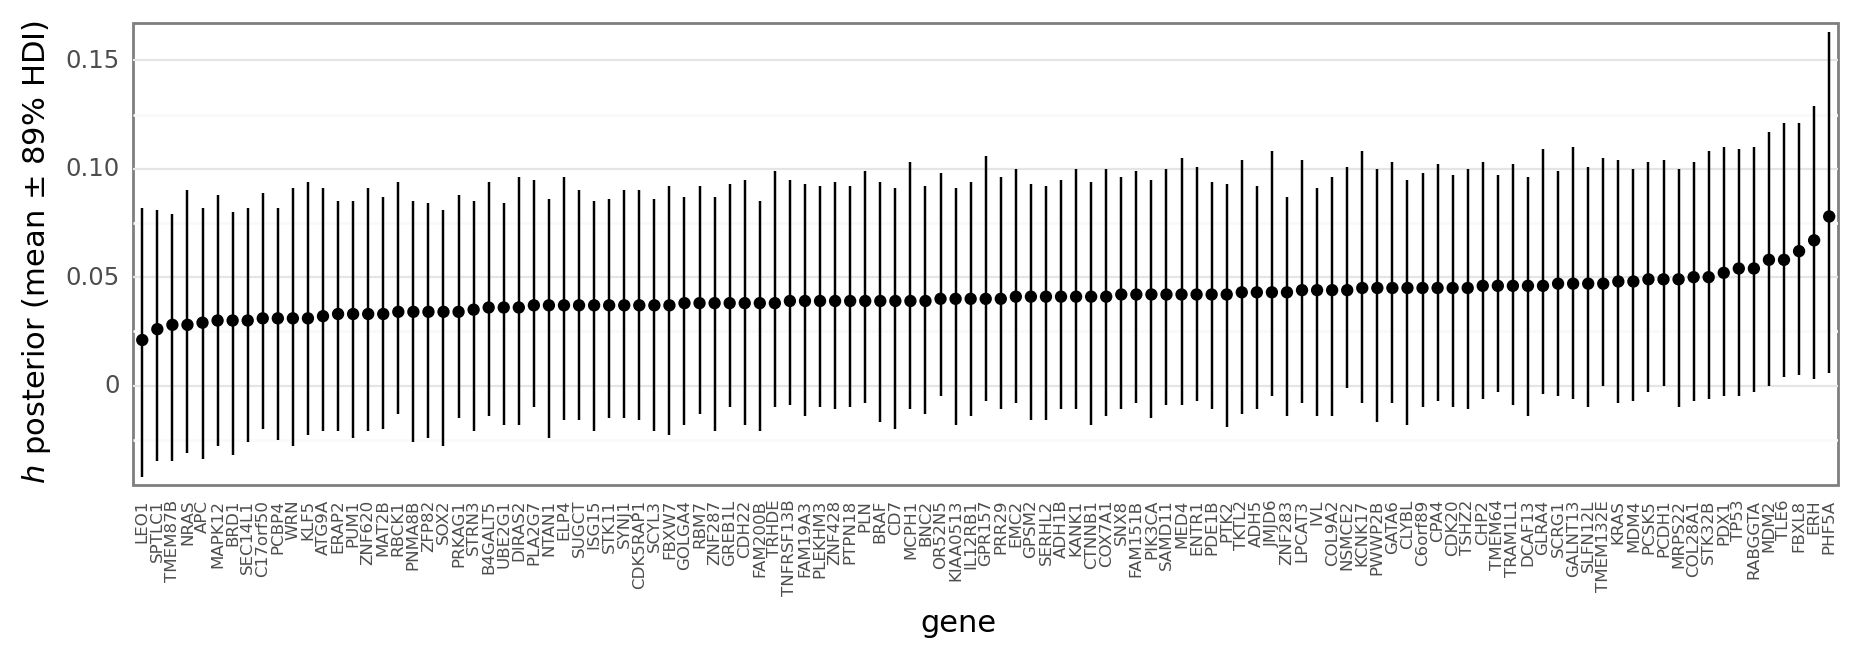

<ggplot: (361396399)>

In [26]:
(
    gg.ggplot(h_post_summary, gg.aes(x="hugo_symbol", y="mean"))
    + gg.geom_linerange(gg.aes(ymin="hdi_5.5%", ymax="hdi_94.5%"))
    + gg.geom_point()
    + gg.scale_y_continuous(expand=(0.02, 0))
    + gg.theme(
        figure_size=(11, 3),
        axis_text_x=gg.element_text(angle=90, size=6),
        panel_grid_major_x=gg.element_blank(),
    )
    + gg.labs(x="gene", y="$h$ posterior (mean ± 89% HDI)")
)

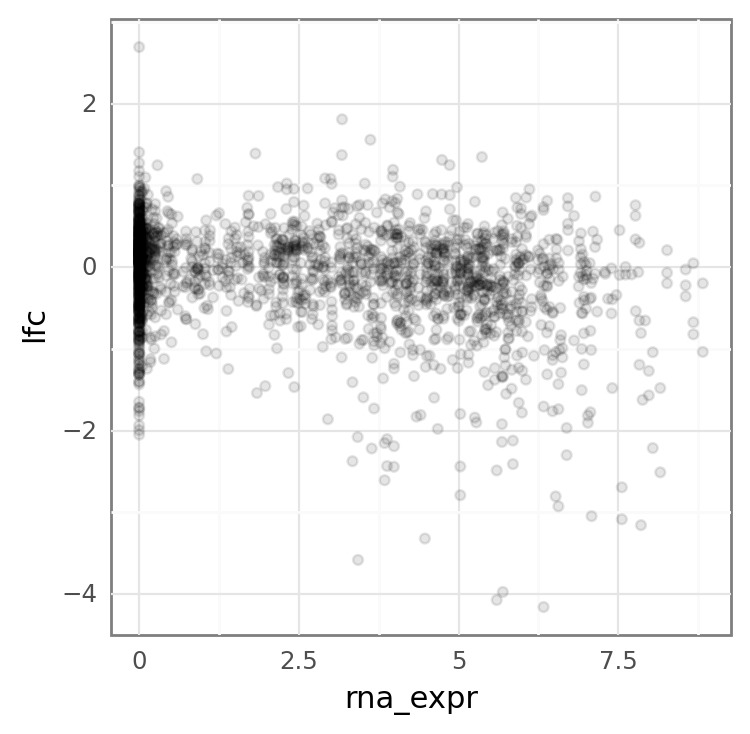

<ggplot: (361777649)>

In [28]:
(gg.ggplot(counts_data, gg.aes(x="rna_expr", y="lfc")) + gg.geom_point(alpha=0.1))

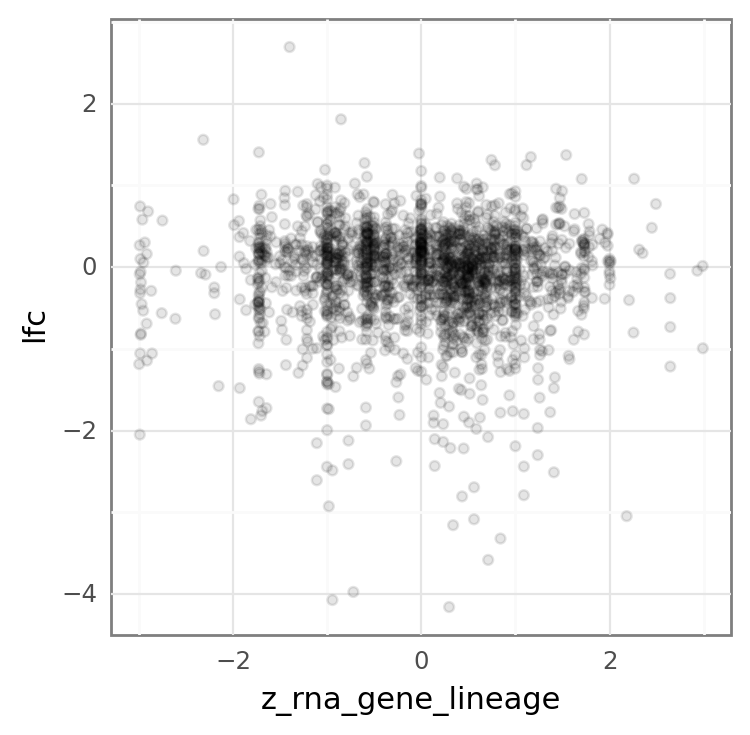

<ggplot: (361368492)>

In [29]:
(
    gg.ggplot(valid_ct_data, gg.aes(x="z_rna_gene_lineage", y="lfc"))
    + gg.geom_point(alpha=0.1)
)

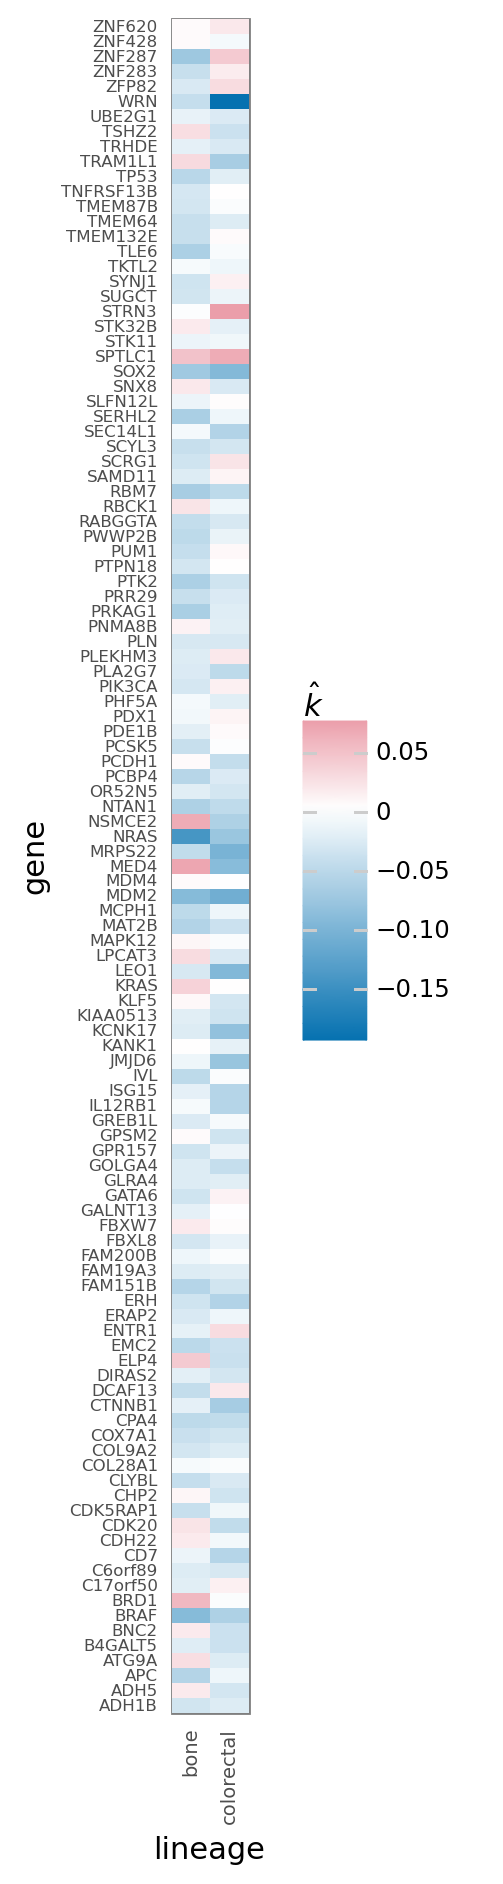

<ggplot: (361864924)>

In [30]:
k_post_summary = (
    az.summary(hnb_trace, var_names=["k"], hdi_prob=HDI_PROB, kind="stats")
    .reset_index(drop=False)
    .pipe(
        extract_matrix_variable_coords,
        col="index",
        idx1name="hugo_symbol",
        idx2name="lineage",
    )
)

(
    gg.ggplot(k_post_summary, gg.aes(x="lineage", y="hugo_symbol"))
    + gg.geom_tile(gg.aes(fill="mean"))
    + gg.scale_x_discrete(expand=(0, 0.5))
    + gg.scale_y_discrete(expand=(0, 0.5))
    + gg.scale_fill_gradient2(low="#0571b0", mid="white", high="#ca0020", midpoint=0)
    + gg.theme(
        figure_size=(0.5, 11),
        axis_text_x=gg.element_text(size=7, angle=90),
        axis_text_y=gg.element_text(size=6),
        panel_grid=gg.element_blank(),
    )
    + gg.labs(x="lineage", y="gene", fill="$\\hat{k}$")
)

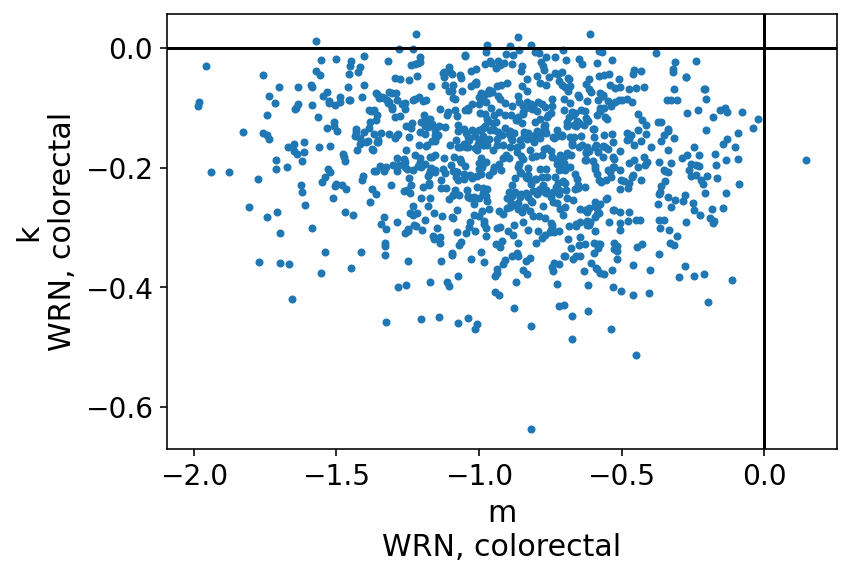

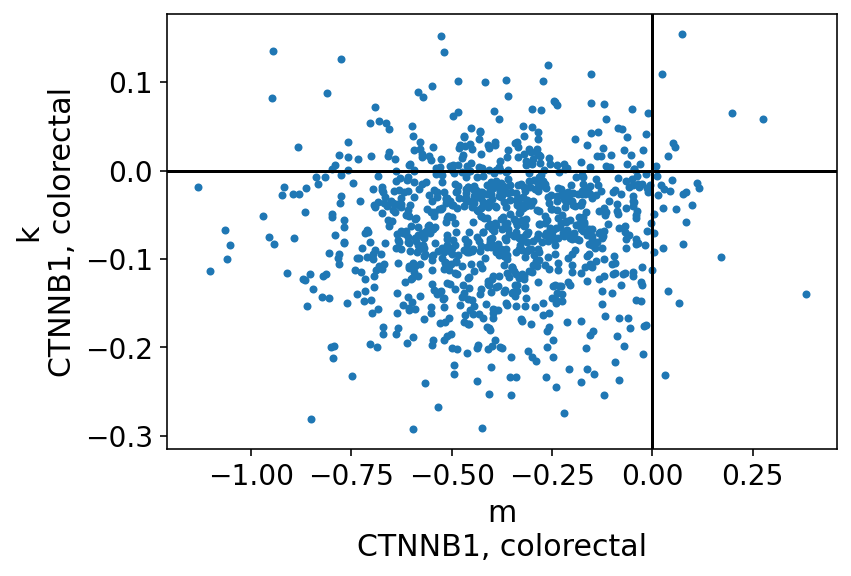

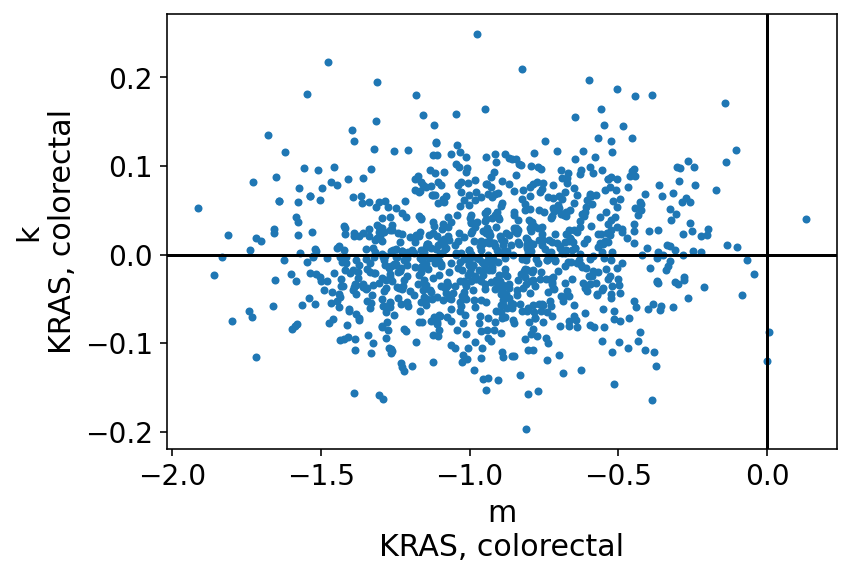

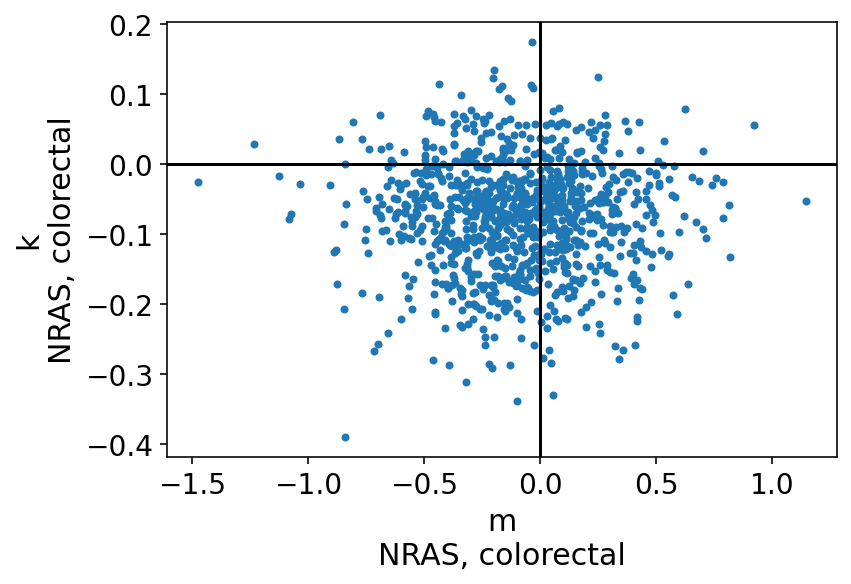

In [31]:
for gene in ["WRN", "CTNNB1", "KRAS", "NRAS"]:
    ax = az.plot_pair(
        hnb_trace,
        var_names=["m", "k"],
        coords={"lineage": ["colorectal"], "gene": [gene]},
    )
    ax.axvline(0, c="k")
    ax.axhline(0, c="k")
    plt.show()

## Posterior predictions

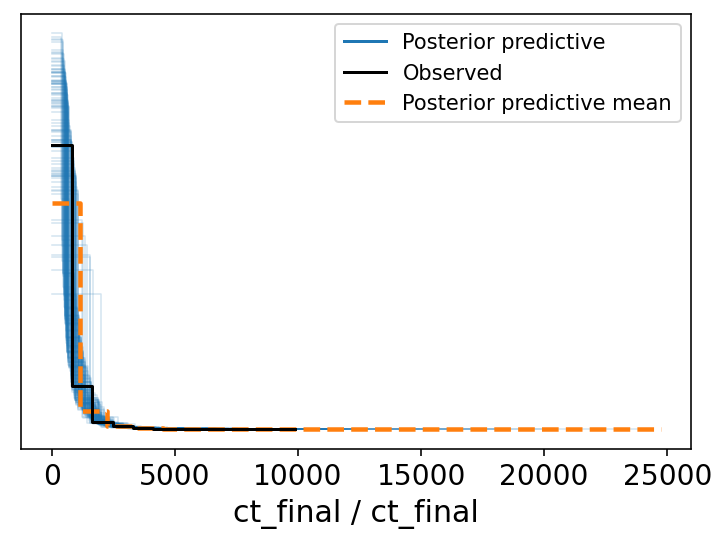

In [32]:
ax = az.plot_ppc(hnb_trace, num_pp_samples=100);

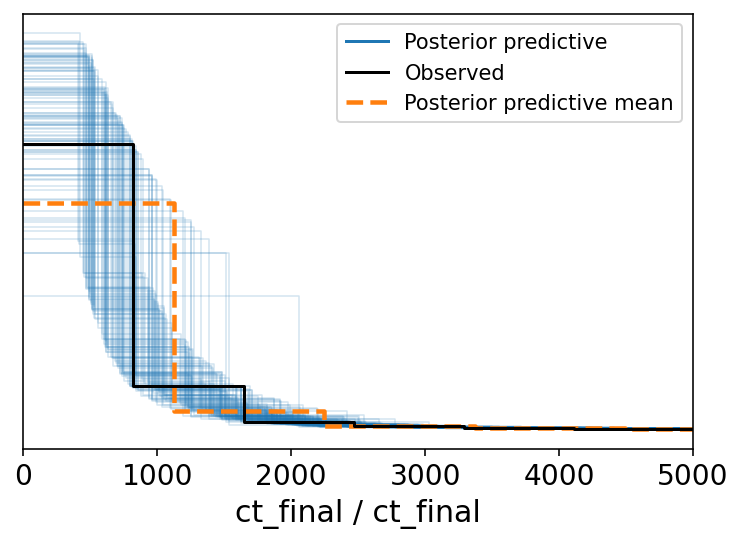

In [33]:
ax = az.plot_ppc(hnb_trace, num_pp_samples=100)
ax.set_xlim(0, 5000);

In [34]:
hnb_post_pred = (
    hnb_trace.posterior_predictive["ct_final"]
    .to_dataframe()
    .reset_index(level=["chain", "draw"], drop=False)
    .assign(grp=lambda d: [f"{chain}-{draw}" for chain, draw in zip(d.chain, d.draw)])
    .rename(columns={"ct_final": "ct_final_pred"})
    .merge(
        valid_ct_data.reset_index()
        .rename(columns={"index": "ct_final_dim_0"})
        .set_index("ct_final_dim_0"),
        left_index=True,
        right_index=True,
    )
)

In [35]:
plt_draws = np.random.choice(hnb_post_pred.grp.unique(), 25, replace=False)

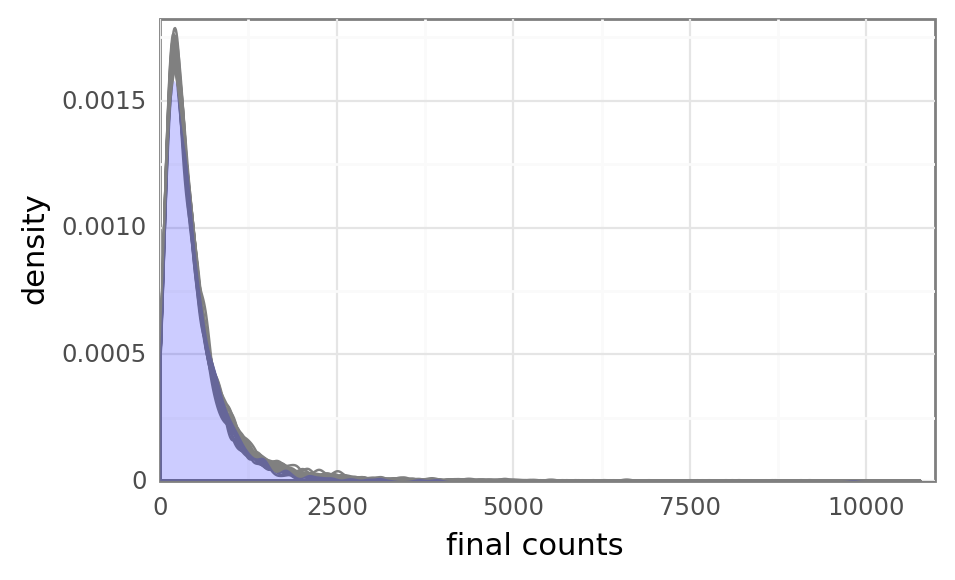

<ggplot: (370628093)>

In [36]:
(
    gg.ggplot(
        hnb_post_pred.filter_column_isin("grp", plt_draws), gg.aes(x="ct_final_pred")
    )
    + gg.geom_density(gg.aes(group="grp"), alpha=0, color="gray")
    + gg.geom_density(
        gg.aes(x="counts_final"), data=valid_ct_data, size=0, fill="blue", alpha=0.2
    )
    + gg.scale_x_continuous(expand=(0, 0, 0.02, 0))
    + gg.scale_y_continuous(expand=(0, 0, 0.02, 0))
    + gg.theme(figure_size=(5, 3))
    + gg.labs(x="final counts")
)

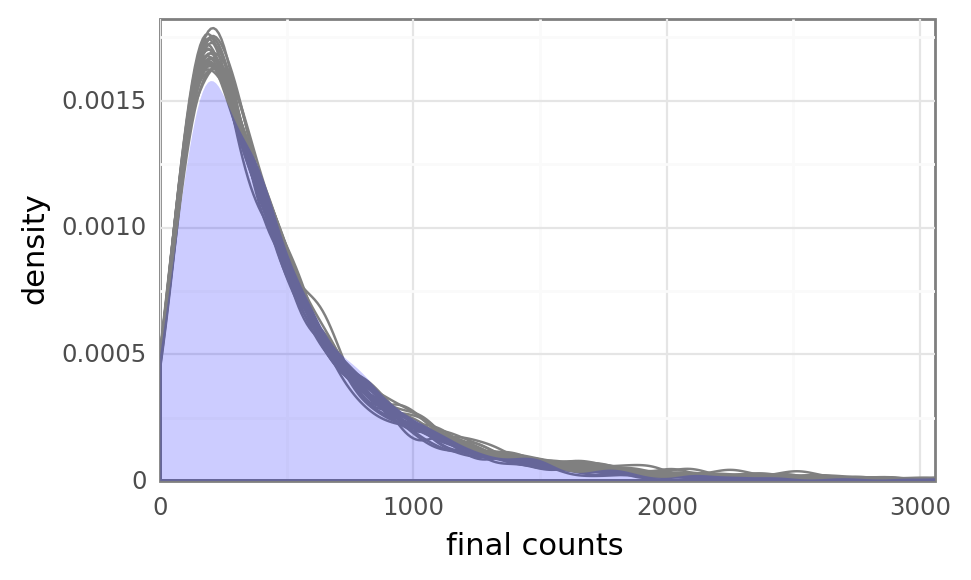

<ggplot: (362589091)>

In [37]:
(
    gg.ggplot(
        hnb_post_pred.filter_column_isin("grp", plt_draws), gg.aes(x="ct_final_pred")
    )
    + gg.geom_density(gg.aes(group="grp"), alpha=0, color="gray")
    + gg.geom_density(
        gg.aes(x="counts_final"), data=valid_ct_data, size=0, fill="blue", alpha=0.2
    )
    + gg.scale_x_continuous(expand=(0, 0, 0.02, 0))
    + gg.scale_y_continuous(expand=(0, 0, 0.02, 0))
    + gg.coord_cartesian(xlim=(0, 3000))
    + gg.theme(figure_size=(5, 3))
    + gg.labs(x="final counts")
)

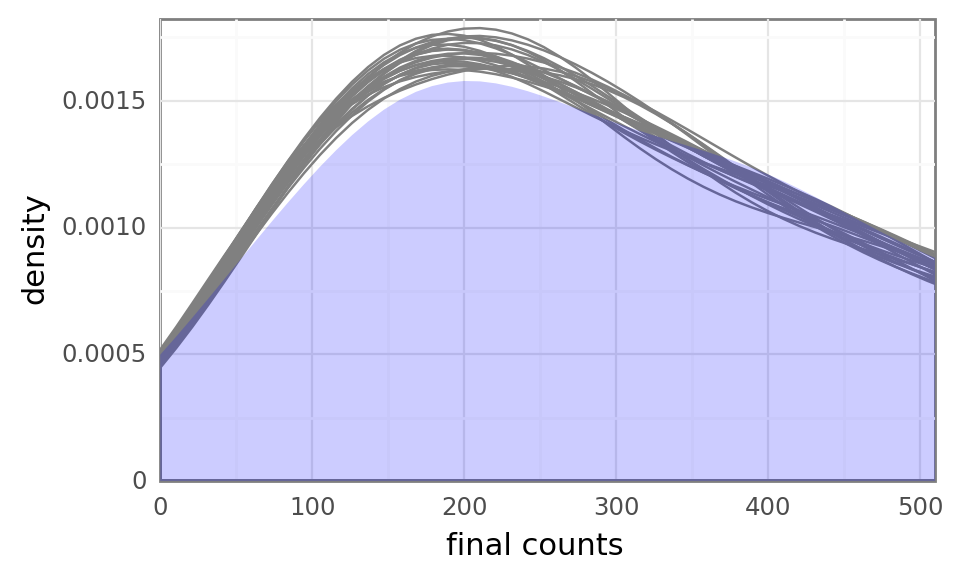

<ggplot: (370690497)>

In [38]:
(
    gg.ggplot(
        hnb_post_pred.filter_column_isin("grp", plt_draws), gg.aes(x="ct_final_pred")
    )
    + gg.geom_density(gg.aes(group="grp"), alpha=0, color="gray")
    + gg.geom_density(
        gg.aes(x="counts_final"), data=valid_ct_data, size=0, fill="blue", alpha=0.2
    )
    + gg.scale_x_continuous(expand=(0, 0, 0.02, 0))
    + gg.scale_y_continuous(expand=(0, 0, 0.02, 0))
    + gg.coord_cartesian(xlim=(0, 500))
    + gg.theme(figure_size=(5, 3))
    + gg.labs(x="final counts")
)

---

In [39]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

execution time: 5.33 minutes


In [40]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2022-03-07

Python implementation: CPython
Python version       : 3.9.9
IPython version      : 8.0.1

Compiler    : Clang 11.1.0 
OS          : Darwin
Release     : 21.3.0
Machine     : x86_64
Processor   : i386
CPU cores   : 4
Architecture: 64bit

Hostname: JHCookMac

Git branch: add-nb-model

janitor   : 0.22.0
numpy     : 1.22.2
arviz     : 0.11.4
plotnine  : 0.8.0
pandas    : 1.4.1
matplotlib: 3.5.1
pymc      : 4.0.0b2
seaborn   : 0.11.2

